In [711]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import matplotlib.ticker as tck
from matplotlib.lines import Line2D
from itertools import cycle

In [712]:
csv_str = """
"Index 1","Index 2","Index 3","Index 4","Metric 1 Ave","Metric 1 Error","Metric 2 Ave","Metric 2 Error","Metric 3 Ave","Metric 3 Error","Metric 4 Ave","Metric 4 Error"
A,B,B,D,10.2,2.1,14.4,1.3,12.4,2.3,10.4,2.3
B,C,C,A,11.3,1.5,13.2,2.3,10.2,1.3,15.2,1.3
A,A,A,C,10.2,2.4,12.1,4.1,10.1,1.1,14.4,1.4
D,C,C,B,14.9,1.2,11.7,2.5,11.7,5.5,11.7,5.5
E,C,C,B,14.9,1.2,10.7,2.5,10.7,0.5,10.7,0.5
G,A,A,A,14.9,1.2,14.7,2.5,11.7,1.5,11.7,1.5
H,A,A,A,14.9,1.2,14.7,2.5,11.7,1.5,11.7,1.5
I,A,A,A,14.9,1.2,19.7,2.5,11.7,1.5,11.7,1.5
J,A,A,A,14.9,1.2,14.7,2.5,11.7,1.5,11.7,1.5
K,A,A,A,14.9,1.2,11.7,2.5,11.7,1.5,11.7,1.5
L,A,A,A,14.9,1.2,14.7,2.5,11.7,1.5,11.7,1.5
"""

In [713]:
# df = pd.read_csv(path / 'example.csv')
df = pd.read_csv(io.StringIO(csv_str))
df

,Index 1,Index 2,Index 3,Index 4,Metric 1 Ave,Metric 1 Error,Metric 2 Ave,Metric 2 Error,Metric 3 Ave,Metric 3 Error,Metric 4 Ave,Metric 4 Error
0,A,B,B,D,10.2,2.1,14.4,1.3,12.4,2.3,10.4,2.3
1,B,C,C,A,11.3,1.5,13.2,2.3,10.2,1.3,15.2,1.3
2,A,A,A,C,10.2,2.4,12.1,4.1,10.1,1.1,14.4,1.4
3,D,C,C,B,14.9,1.2,11.7,2.5,11.7,5.5,11.7,5.5
4,E,C,C,B,14.9,1.2,10.7,2.5,10.7,0.5,10.7,0.5
5,G,A,A,A,14.9,1.2,14.7,2.5,11.7,1.5,11.7,1.5
6,H,A,A,A,14.9,1.2,14.7,2.5,11.7,1.5,11.7,1.5
7,I,A,A,A,14.9,1.2,19.7,2.5,11.7,1.5,11.7,1.5
8,J,A,A,A,14.9,1.2,14.7,2.5,11.7,1.5,11.7,1.5
9,K,A,A,A,14.9,1.2,11.7,2.5,11.7,1.5,11.7,1.5


In [714]:
def dicrete_plot(df, index_columns, metric_columns, error_columns, 
        unit=1.0, scale=1.0, border=2.0, legend_offset=1.0, capsize=10, barplot_margin=1.0, enable_minor_grid=True):
    # Initial assertions:
    if len(index_columns) == 0:
        raise ValueError('Empty list given, index_columns must be non-empty list')
    if len(metric_columns) == 0 or len(error_columns) == 0:
        raise ValueError('Empty list given, metric_columns and error_columns must be non-empty list')
    if len(metric_columns) != len(error_columns):
        raise ValueError('metric_columns and error_columns must be lists of equal size')
    # Extract labels:
    labels = {index_name: np.sort(df[index_name].unique()) for index_name in index_columns}
    # Specify GridSpec:
    widths = np.array([unit] * len(labels) + [6*unit])
    heights = np.array([unit] * len(df) + [legend_offset*unit])
    gs_kw = dict(width_ratios=widths, height_ratios=heights)
    fig, axs = plt.subplots(
        ncols=len(widths), nrows=len(heights), subplot_kw=dict(frameon=False),
        constrained_layout=False, gridspec_kw=gs_kw, 
        figsize=(scale * widths.sum(), scale * heights.sum()))
    # Define color mappings:
    from matplotlib.cm import get_cmap
    cmaps = cycle(['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', ])
    def map_disc_(items, cmap_name):
        cmap_ = get_cmap(cmap_name)
        inter_ = 0.3
        slope_ = (1. - inter_) / len(items)
        return {value: cmap_(inter_ + items.tolist().index(value) * slope_) for value in items}
    colors = {label: map_disc_(items, cmap_name) \
        for (label, items), cmap_name in zip(labels.items(), cmaps)}
    # Find maximum value for metrics including error:
    max_m_e = pd.DataFrame({m + ' + ' + e: df[m] + df[e] \
        for i, (m, e) in enumerate(zip(metric_columns, error_columns))}).to_numpy().max()
    # Apply settings for axes:
    for r, row in enumerate(axs):
        for c, ax in enumerate(row):
            for _, spine in ax.spines.items():
                spine.set_visible(False)
            if r == len(axs) - 1:
                ax.set(xticks=[], yticks=[])
                ax.patch.set_alpha(0.)
                continue
            if c < len(labels):
                ax.set(xticks=[], yticks=[])
                var_name = list(labels.keys())[c]
                var_value = df[var_name][r]
                ax.add_patch(pch.Rectangle((0., 0.), 1., 1., 
                    facecolor=colors[var_name][var_value], edgecolor='black', label=var_value))
                for _, spine in ax.spines.items():
                    spine.set_linewidth(border)
            else:
                ax.set_xlim(0., max_m_e + barplot_margin)
                ax.set(yticks=[])
                ax.tick_params(grid_linestyle='solid', color='grey', zorder=0)
                if enable_minor_grid:
                    ax.tick_params(which='minor', grid_linestyle='dashed', grid_dashes=(3, 6), color='grey', zorder=0)
                    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
                ax.grid(which='both')
                if r < len(axs) - 2: 
                    ax.tick_params(labelbottom=False, length=10)
                if r == len(axs) - 2: 
                    ax.tick_params(labelbottom=True)
                    ax.spines['bottom'].set_visible(True)
                cmap = get_cmap('Greys')
                ax.patch.set_alpha(0.)
                inter_ = 0.1
                slope_ = (1. - inter_) / len(metric_columns)
                for i, (metric_name, error) in enumerate(zip(metric_columns, error_columns)):
                    clr = cmap(inter_ + (i + 1) * slope_)
                    ax.barh([i], [df[metric_name][r]], xerr=[[0.], [df[error][r]]], 
                        color=clr, edgecolor='black', height=1., capsize=capsize, label=metric_name, zorder=10.)
                handles, lbs = ax.get_legend_handles_labels()
    # Build the legend:
    sizes = [ll.shape[0] for ln, ll in labels.items()]
    largest_label_inx = np.argmax(sizes)
    ## Categorical variables:
    hndl = []
    for i, (lbl, colors_) in enumerate(colors.items()):
        size, empty = len(colors_), []
        if i >= 1:
            m = sizes[largest_label_inx] - sizes[i - 1]
            if m > 0:
                empty = [Line2D([], [], label='', alpha=0.)] * m
        hndl += empty + [Line2D([], [], label=lbl, alpha=0.)] + [
            pch.Patch(facecolor=color, edgecolor="k", label=label, alpha=0.7) 
            for label, color in colors_.items()
        ]
    ## Continuous variables:
    empty = []
    m = sizes[largest_label_inx] - sizes[-1] + 1
    if m > 0:
        empty = [Line2D([], [], label='', alpha=0.)] * m
    hndl += empty + handles + [
        Line2D([], [], label='', alpha=0.)] * (sizes[largest_label_inx] - len(metric_columns))
        
    legend = fig.legend(handles=hndl, loc='lower center', handlelength=scale*1.4, handleheight=scale*1.6, ncol=len(index_columns) + 1, labelspacing=.0)
    legend.get_frame().set_alpha(0.)
    plt.subplots_adjust(hspace=0.1, wspace=0.)
    return fig

# Demo

## Many indices, many metrics

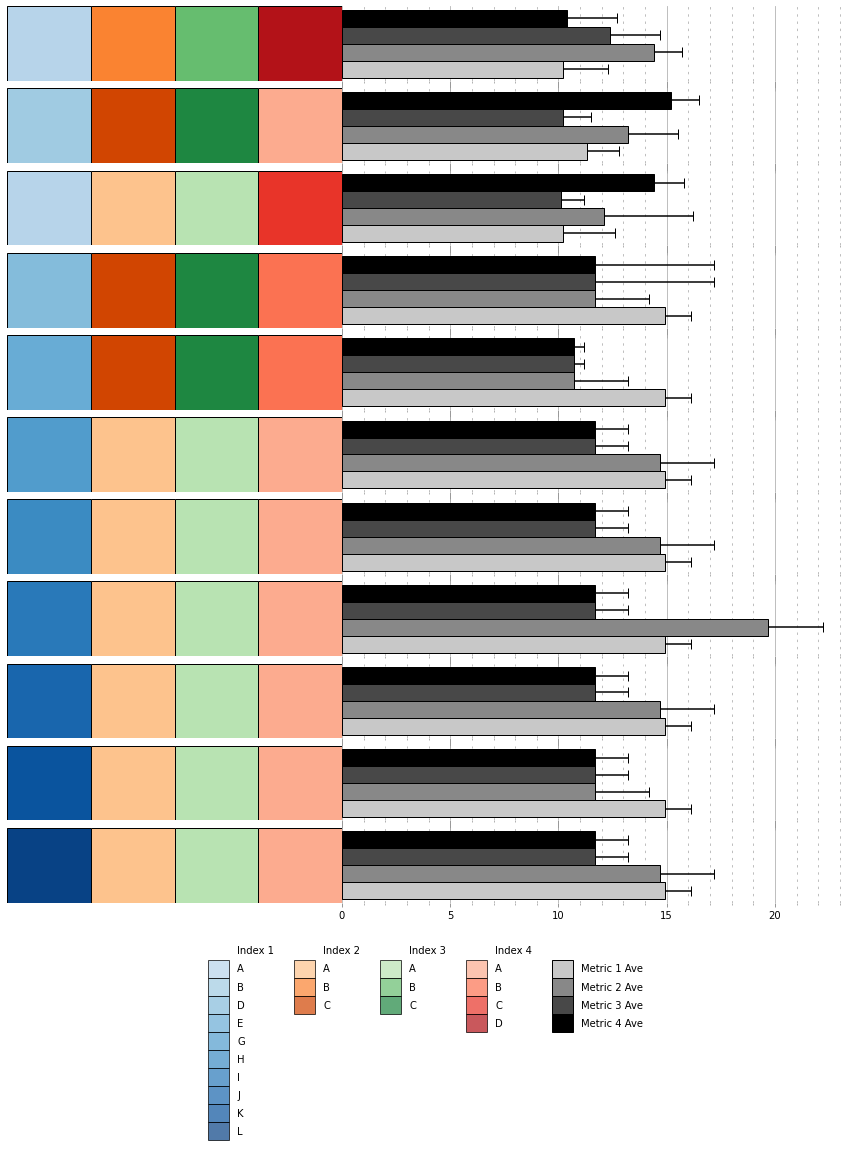

In [715]:
index_columns=['Index 1', 'Index 2', 'Index 3', 'Index 4']
metric_columns = ['Metric 1 Ave', 'Metric 2 Ave', 'Metric 3 Ave', 'Metric 4 Ave']
error_columns = ['Metric 1 Error', 'Metric 2 Error', 'Metric 3 Error', 'Metric 4 Error']
fig = dicrete_plot(df, index_columns, metric_columns, error_columns, border=1., scale=1.5, legend_offset=1., capsize=5)

In [716]:
# Export to svg file:
fig.savefig('test.svg')

## Many indices, single metric

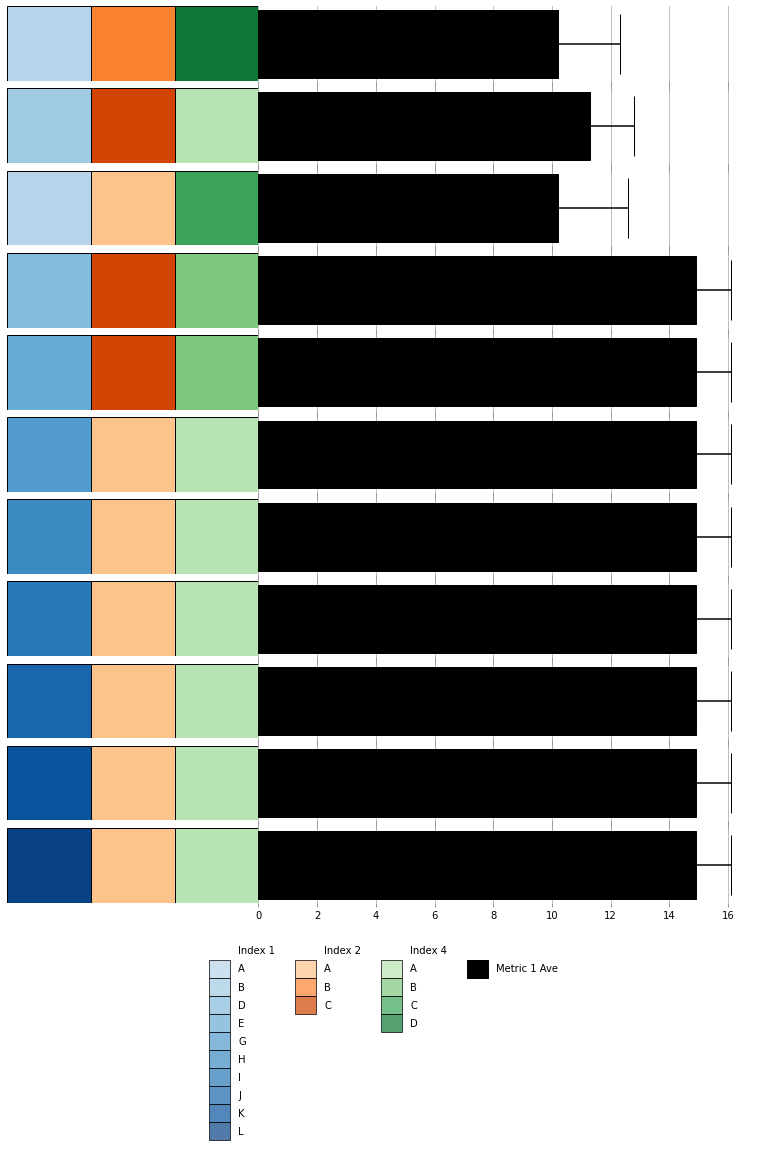

In [720]:
index_columns=['Index 1', 'Index 2', 'Index 4']
metric_columns = ['Metric 1 Ave']
error_columns = ['Metric 1 Error']
fig = dicrete_plot(df, index_columns, metric_columns, error_columns, scale=1.5, legend_offset=1., capsize=30, enable_minor_grid=False)

## Single index, many metrics

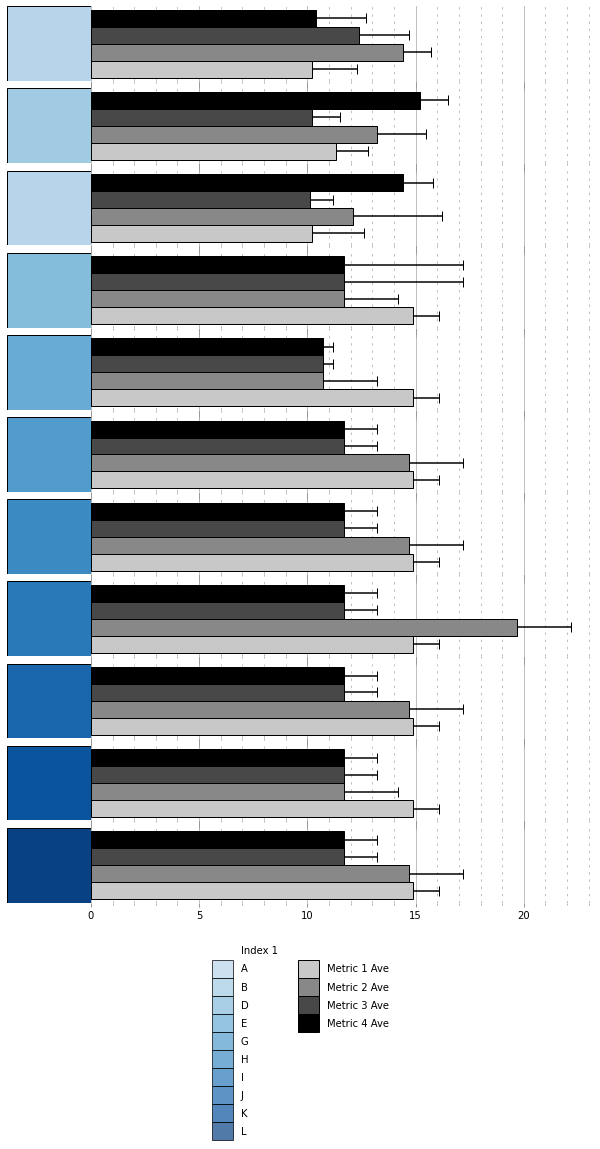

In [718]:
index_columns=['Index 1']
metric_columns = ['Metric 1 Ave', 'Metric 2 Ave', 'Metric 3 Ave', 'Metric 4 Ave']
error_columns = ['Metric 1 Error', 'Metric 2 Error', 'Metric 3 Error', 'Metric 4 Error']
fig = dicrete_plot(df, index_columns, metric_columns, error_columns, scale=1.5, legend_offset=1., capsize=5)